# Bài Lab: Giảm chiều và Trực quan hóa Vector Từ GloVe

**Mục tiêu:**
- Sử dụng mô hình embedding GloVe (hoặc Word2Vec/FastText) để biểu diễn từ dưới dạng vector nhiều chiều.
- Giảm chiều các vector này xuống còn 2D hoặc 3D bằng các kỹ thuật PCA hoặc t-SNE.
- Trực quan hóa các từ để quan sát mối quan hệ ngữ nghĩa giữa chúng.

**Phương pháp sử dụng:**
- Mô hình: GloVe (hoặc Word2Vec/FastText) 100 chiều (pre-trained).
- Giảm chiều: PCA và t-SNE.
- Thư viện: `gensim`, `matplotlib`, `scikit-learn`.

---

## **Cài thư viện và tải mô hình GloVe**

In [2]:
#!pip install gensim scikit-learn matplotlib

In [9]:
# # Tải file GloVe (nếu chưa có)
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [11]:
# Chuyển file glove.6B.50d.txt sang định dạng Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.50d.txt'        
word2vec_output_file = 'glove.6B.50d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load mô hình GloVe
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
print("Đã load xong GloVe 50d.")
print("Số lượng từ trong mô hình:", len(model.index_to_key))

/tmp/ipykernel_15235/3102255366.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


Đã load xong GloVe 50d.
Số lượng từ trong mô hình: 400000


### Giải thích
File `glove.6B.50d.txt` không có dòng metadata, nên cần chuyển sang định dạng Word2Vec để `gensim` có thể đọc được.
Việc này chỉ thêm dòng đầu mô tả số từ và số chiều, **không làm thay đổi giá trị vector**.

## **Giảm chiều**

In [16]:
# !pip install tqdm

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualize_pca(model, words=None, n_components=2, sample_size=None, title=None, annotate=True):
    """
    Giảm chiều bằng PCA và trực quan hóa vector từ mô hình embedding (GloVe, Word2Vec...).
    """
    # Chọn tập từ
    if words is None:
        vocab = model.index_to_key
        if sample_size:
            vocab = vocab[:sample_size]
    else:
        vocab = [w for w in words if w in model.key_to_index]

    print(f"Đang trực quan hóa {len(vocab)} từ bằng PCA...")

    # Lấy vector
    vectors = np.array([model[w] for w in vocab])

    # Giảm chiều
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(vectors)

    # Vẽ biểu đồ
    if n_components == 2:
        plt.figure(figsize=(10,8))
        plt.scatter(reduced[:,0], reduced[:,1], s=10)
        if annotate:
            for i, word in enumerate(vocab):
                plt.annotate(word, xy=(reduced[i,0], reduced[i,1]), fontsize=8)
        plt.title(title or f"Trực quan hóa {len(vocab)} từ (PCA - 2D)")
        plt.xlabel("Chiều 1")
        plt.ylabel("Chiều 2")
        plt.show()


## **PCA**

### Thử giảm chiều toàn bộ dữ liệu

Đang trực quan hóa 400000 từ bằng PCA...


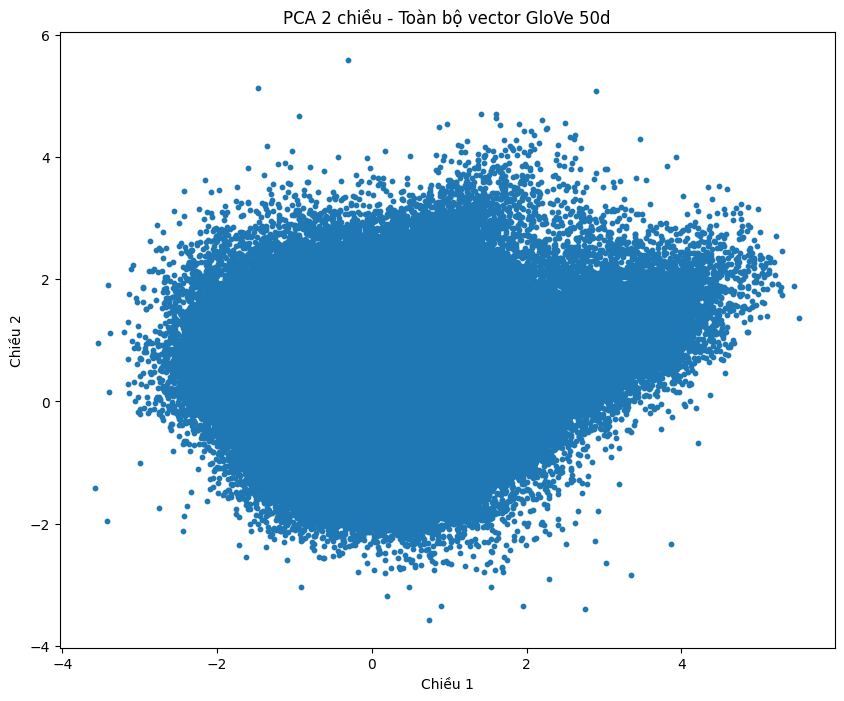

In [42]:
# Giảm chiều toàn bộ không gian vector (400.000 từ)
visualize_pca(model, annotate=False, 
              title="PCA 2 chiều - Toàn bộ vector GloVe 50d")

**Nhận xét PCA toàn bộ GloVe**

Biểu đồ PCA toàn bộ cho thấy các vector từ phân bố thành một khối dày đặc dạng “đám mây” trải đều theo hai trục chính.  
Điều này phản ánh cấu trúc tổng thể của không gian GloVe 50 chiều khi nén xuống 2 chiều:  
- PCA chỉ giữ lại ~X% phương sai, chủ yếu thể hiện mức độ phổ biến hoặc chức năng của từ.  
- Các nhóm nghĩa chưa tách biệt rõ ràng vì 2D không đủ thể hiện toàn bộ quan hệ trong 50D.  
Biểu đồ này phù hợp để quan sát tổng thể nhưng chưa cho thấy cụm ngữ nghĩa cụ thể.


### Trực quan hóa nhóm từ nhỏ bằng PCA

Đang trực quan hóa 200 từ bằng PCA...


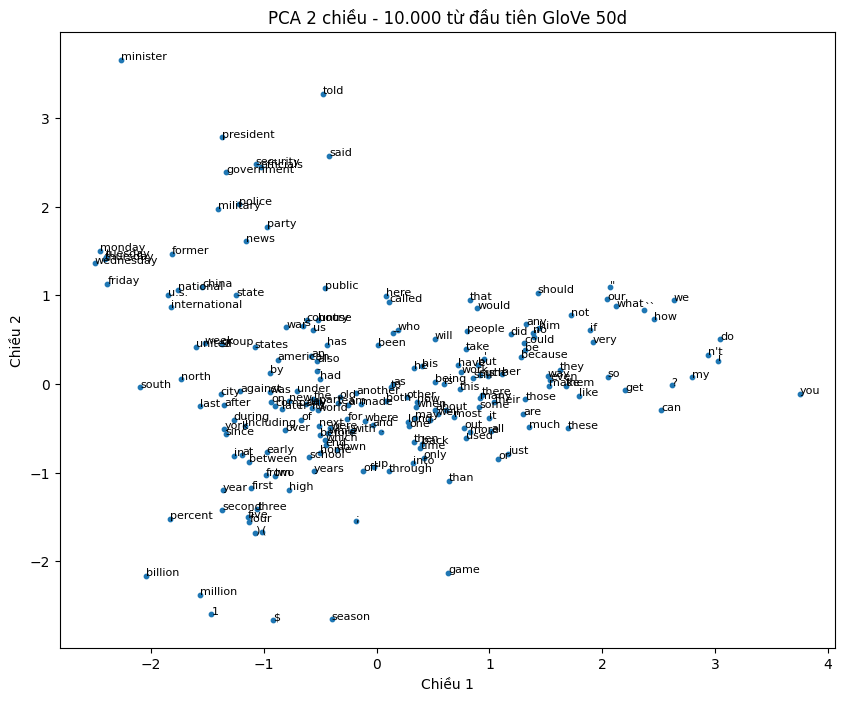

In [48]:
# Giảm chiều cho 10.000 từ đầu tiên
visualize_pca(model, sample_size=200, annotate=True, 
              title="PCA 2 chiều - 10.000 từ đầu tiên GloVe 50d")


**Nhận xét PCA 200 từ đầu tiên**

Biểu đồ PCA 2 chiều của 200 từ đầu tiên trong mô hình GloVe cho thấy các điểm dữ liệu đã bắt đầu phân tán rõ hơn so với biểu đồ toàn bộ.  
Một số từ có xu hướng nhóm lại thành cụm nhỏ phản ánh phần nào sự tương đồng ngữ nghĩa hoặc ngữ cảnh sử dụng, tuy chưa thật sự tách biệt hoàn toàn.  

Các từ phổ biến (như *and, of, that, who, people…*) nằm gần vùng trung tâm, cho thấy PCA ưu tiên trục biểu diễn tần suất và chức năng ngôn ngữ.  
Những từ mang nghĩa cụ thể hơn (*president, minister, american, billion, percent…*) có xu hướng nằm rìa, thể hiện sự khác biệt ngữ nghĩa so với các từ chức năng.  

Nhìn chung, khi giảm xuống 2 chiều, PCA giúp quan sát được cấu trúc phân bố tổng quát và phát hiện một phần các mối liên hệ ngữ nghĩa, nhưng vẫn chưa đủ để


### Thử 1 nhóm cụ thể

Đang trực quan hóa 16 từ bằng PCA...


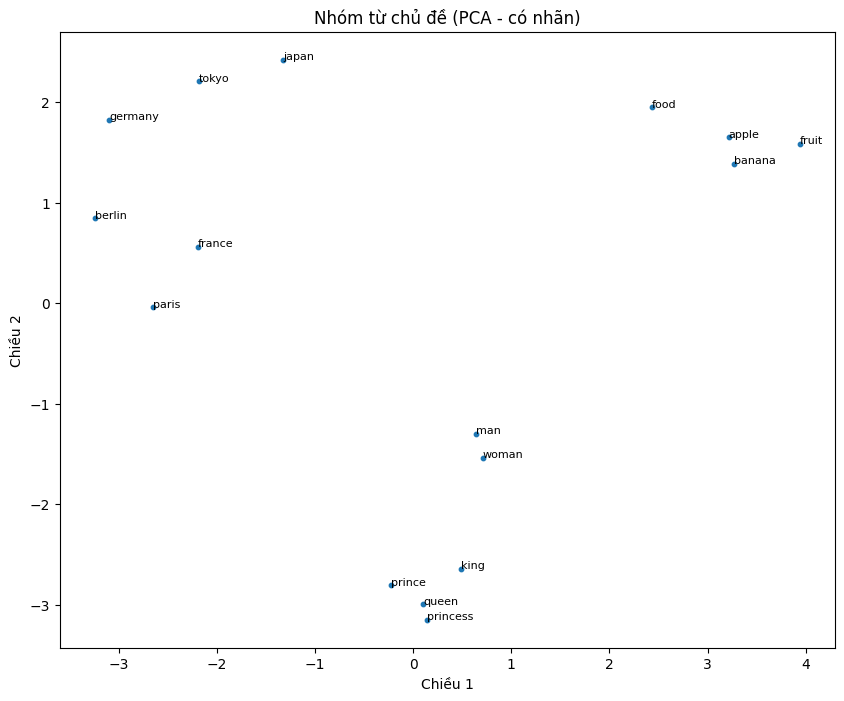

In [49]:
words = [
    'king', 'queen', 'man', 'woman', 'prince', 'princess',
    'paris', 'france', 'berlin', 'germany', 'tokyo', 'japan',
    'apple', 'banana', 'fruit', 'food'
]
visualize_pca(model, words=words, annotate=True, 
              title="Nhóm từ chủ đề (PCA - có nhãn)")

**Nhận xét PCA cho nhóm từ cụ thể**

Biểu đồ PCA cho thấy các từ có xu hướng phân nhóm rõ ràng theo chủ đề ngữ nghĩa:

- Nhóm hoàng gia & giới tính gồm *king, queen, prince, princess, man, woman* nằm gần nhau -> thể hiện mối quan hệ “giới - vai trò quyền lực”.
- Nhóm quốc gia - thủ đô (*france-paris*, *germany-berlin*, *japan-tokyo*) nằm gần nhau, phản ánh đúng quan hệ địa lý ngữ nghĩa.
- Nhóm thực phẩm - hoa quả (*apple, banana, fruit, food*) tạo cụm riêng ở phía đối diện, tách biệt với các nhóm còn lại.

Mặc dù chỉ giảm còn 2 chiều nên một số khoảng cách chưa hoàn toàn chính xác, PCA vẫn thể hiện được khả năng học quan hệ ngữ nghĩa của mô hình GloVe thông qua vị trí tương đối giữa các từ.
